In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import animation
from mpl_toolkits.basemap import Basemap
import contextily as cx  
import xarray as xr
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LinearSegmentedColormap
from scipy.spatial import cKDTree
from datetime import datetime
from matplotlib import gridspec
import scipy.stats as stats
import wavespectra
import netCDF4 as nc
import h5py
import numbers
import copy
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import pymannkendall as mk
import calendar
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
import re
from scipy.stats import norm
import glob

In [2]:
base_path = "/gpfs/work3/0/ai4nbs/hurry_wave/north_sea"
output_dir = '/gpfs/work3/0/ai4nbs/hurry_wave/north_sea/05_postprocessing/Wind/Test'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# parser = argparse.ArgumentParser(description="Postprocess Hurrywave output.")
# parser.add_argument("--model_name", type=str, required=True, help="Name of the model run")
# parser.add_argument("--data_name", type=str, required=True, help="Name of the data set")
# args = parser.parse_args()

# model_name = args.model_name
# data_name = args.data_name

year_start = 2013 # Latest year
year_end = 2013 # Earliest year

month_start = 12 # Latest month
month_end = 1 # Earliest month

day_start = 31 # Latest day
day_end = 1 # Earliest day

hour_start = 23 # Latest hour
hour_end = 0 # Earliest hour

years  = np.arange(year_start, year_end - 1, -1)
months = np.arange(month_start, month_end - 1, -1)
days   = np.arange(day_start, day_end - 1, -1)
hours  = np.arange(hour_start, hour_end - 1, -1)

run_tests = True

area = [65, -12, 48, 10] # DCSM area in the North Sea (degrees): North, West, South, East

# model_path = os.path.join(base_path, '04_modelruns', 'YearSims',model_name)
 
model_path = os.path.join(base_path, '04_modelruns', 'YearSims')
model_path_start = os.path.join(model_path, str(year_start)) 
postprocess_path = os.path.join(base_path, '05_postprocessing', 'his_files_per_station')
spectral_data_path = os.path.join(base_path, '01_data', 'spectral_buoy_data')
ERA5_data_path = '/gpfs/work3/0/ai4nbs/ERA5_data/data'
Wind_data_path = os.path.join(base_path, '01_data', 'Wind_data')


inp_file = os.path.join(model_path_start, 'hurrywave.inp')
tstart = f"{year_end}{month_end}{day_end} {hour_end}0000" # earliest time
tstop = f"{year_start}{month_start}{day_start} {hour_start}0000" # latest time

# DCSM bounding box: [North, West, South, East]
area = area  # (N, W, S, E)

# Find the start and stop times from the input file
with open(inp_file, 'r') as f:
    for line in f:
        if line.strip().startswith('tspinup'):
            tspinup = line.split('=')[1].strip()


# Ensure time is in "yyyymmdd hhmmss" format
def parse_time(s):
    parts = s.strip().split()
    if len(parts) == 2:
        date, time = parts
    elif len(parts) == 1:
        date = parts[0][:8]
        time = parts[0][8:] if len(parts[0]) > 8 else "000000"
    else:
        date, time = "00000000", "000000"  # fallback
    return f"{date} {time}"


tstart_str = parse_time(tstart)
tstop_str = parse_time(tstop)

tstart_dt = datetime.strptime(tstart_str, "%Y%m%d %H%M%S")
tstop_dt = datetime.strptime(tstop_str, "%Y%m%d %H%M%S")

In [3]:
def read_stations_from_obs(file_path):
    """
    Reads station coordinates and names from a .obs file.

    Returns:
        xs (list[float]): x coordinates
        ys (list[float]): y coordinates
        names (list[str]): station names
    """
    xs, ys, names = [], [], []
    with open(file_path, 'r') as f:
        for line in f:
            if '#' in line:
                parts = line.strip().split()
                x = float(parts[0])
                y = float(parts[1])
                name = " ".join(parts[3:])  # everything after "#"
                xs.append(x)
                ys.append(y)
                names.append(name)
    return xs, ys, names

# Example usage
obs_file_path = os.path.join(model_path_start, 'hurrywave.obs')
xs, ys, station_names = read_stations_from_obs(obs_file_path)

def his_remove_spinup(year, model_base_path, his):
    # Find the start and stop times from the input file
    inp_file = os.path.join(model_base_path, str(year), 'hurrywave.inp')
    with open(inp_file, 'r') as f:
        for line in f:
            if line.strip().startswith('tspinup'):
                tspinup = line.split('=')[1].strip()

    tspinup_sec = int(tspinup)
    his_time_vals = his["time"].values
    spinup_end_time = his_time_vals[0] + np.timedelta64(tspinup_sec, 's')
    his_spinup_mask = his_time_vals >= spinup_end_time
    his = his.sel(time=his_spinup_mask)
    return his

In [4]:
def read_stations_from_obs(file_path):
    xs, ys, names = [], [], []
    with open(file_path, 'r') as f:
        for line in f:
            if '#' in line:
                parts = line.strip().split()
                x = float(parts[0])
                y = float(parts[1])
                name = " ".join(parts[3:])
                xs.append(x)
                ys.append(y)
                names.append(name)
    return xs, ys, names


def process_station_data(model_base_path, outdir, y0, y1, save=True):
    print('Starting Hurrywave station extraction...')

    years = np.arange(y0, y1 + 1)
    data_per_station = {}

    for y in years:
        print(f'Processing year: {y}')
        # Read station coordinates from obs file
        obs_file_path = os.path.join(model_base_path,str(y), 'hurrywave.obs')
        xs, ys, station_names_obs = read_stations_from_obs(obs_file_path)
        station_coord_map = {name: (x, y) for name, x, y in zip(station_names_obs, xs, ys)}
        fname = os.path.join(model_base_path, str(y), 'hurrywave_his.nc')
        ds = xr.open_dataset(fname)

        ds = his_remove_spinup(y, model_base_path, ds)

        nstations = ds.dims['stations']
        station_names = ds['station_name'].astype(str).values

        # Select only point variables with dims (time, stations)
        data_vars = [v for v in ds.data_vars if ds[v].dims == ('time', 'stations')]
        time = ds['time'].values

        for i in range(nstations):
            station = station_names[i].strip()
            print(f'  - Extracting {station}')

            if station not in data_per_station:
                data_per_station[station] = {var: [] for var in data_vars}
                data_per_station[station]['time'] = []

                # Add station coordinates
                data_per_station[station]['station_x'] = station_coord_map[station_names_obs[i]][0]
                data_per_station[station]['station_y'] = station_coord_map[station_names_obs[i]][1]

            # Append year’s data for each variable
            for var in data_vars:
                data_per_station[station][var].append(ds[var].isel(stations=i).values)
            data_per_station[station]['time'].append(time)

        ds.close()

    # Concatenate lists into arrays per station
    for station in data_per_station.keys():
        for key in data_per_station[station]:
            if isinstance(data_per_station[station][key], list) and key not in ('station_x', 'station_y'):
                data_per_station[station][key] = np.concatenate(data_per_station[station][key])

    if save:
        print('All years loaded. Starting export...')
        os.makedirs(outdir, exist_ok=True)

        for station, data in data_per_station.items():
            outpath = os.path.join(outdir, f'{station}.npz')
            np.savez(outpath, **data)
            print(f'  ✓ Saved {station}.npz with {len(data["time"])} timesteps.')

        print(f'Extraction finished. Data saved to: {outdir}')
    else:
        print(f'Extraction complete. Data not saved (save=False).')

    return data_per_station, station_names_obs

In [5]:
data_per_station, station_names = process_station_data(
    model_base_path=model_path,
    outdir=postprocess_path,
    y0=year_end,
    y1=year_start,
    save=False
)

# Map station IDs to station names using the station_names list
station_ids = list(data_per_station.keys())
if len(station_ids) != len(station_names):
    raise ValueError(f"Number of station IDs ({len(station_ids)}) and station names ({len(station_names)}) do not match.")

else:
    data_per_station_named = {}
    for sid, sname in zip(station_ids, station_names):
        data_per_station_named[sname] = data_per_station[sid]
    data_per_station = data_per_station_named

# Create a dictionary mapping station names to their depth value
depths = {station: float(data_per_station[station]['point_depth'][0]) for station in station_names}

Starting Hurrywave station extraction...
Processing year: 2013


/scratch-local/72649/ipykernel_1338493/975380268.py:33: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nstations = ds.dims['stations']


  - Extracting station_001
  - Extracting station_002
  - Extracting station_003
  - Extracting station_004
  - Extracting station_005
  - Extracting station_006
  - Extracting station_007
  - Extracting station_008
Extraction complete. Data not saved (save=False).


In [6]:
model_var_names = list(data_per_station['Euro platform'].keys())
model_var_names.remove('time')
model_var_names.remove('station_x')
model_var_names.remove('station_y')

def remove_concatenation_outliers(time_array, *data_arrays,year_start=year_start, year_end=year_end):
    """
    Remove entries where two consecutive times are both midnight (00:00:00).
    If this occurs, remove the entry of the first midnight.

    Args:
        time_array (np.ndarray or pd.Series): Array of datetime64 or pandas Timestamps.
        *data_arrays: Any number of arrays (same length as time_array) to filter in sync.

    Returns:
        filtered_time, filtered_data_arrays...
    """

    # Convert to pandas DatetimeIndex for easy hour extraction
    time_pd = pd.to_datetime(time_array)
    # For DatetimeIndex, use .hour, .minute, .second directly (no .dt needed)
    is_midnight = (time_pd.hour == 0) & (time_pd.minute == 0) & (time_pd.second == 0)
    # Find consecutive midnights
    consecutive_midnight = is_midnight[:-1] & is_midnight[1:]
    # Indices to remove: the first of each consecutive midnight pair
    remove_idx = np.where(consecutive_midnight)[0]
    # Build mask: True = keep, False = remove
    mask = np.ones(len(time_array), dtype=bool)
    mask[remove_idx] = False
    mask[-1] = False  # Always remove the last entry
    
    filtered_time = time_array[mask]
    filtered_data_arrays = [arr[mask] for arr in data_arrays]
    if filtered_data_arrays:
        return (filtered_time, *filtered_data_arrays)
    else:
        return filtered_time
    
# Apply to each station and all model variables (except time/station_x/station_y)
for station in station_names:
    time = data_per_station[station]['time']
    data_arrays = [data_per_station[station][var] for var in model_var_names if var in data_per_station[station]]
    filtered_results = remove_concatenation_outliers(time, *data_arrays)
    if len(filtered_results) == len(data_arrays) + 1:
        filtered_time = filtered_results[0]
        filtered_data_arrays = filtered_results[1:]
        data_per_station[station]['time'] = filtered_time
        for var, arr in zip(model_var_names, filtered_data_arrays):
            data_per_station[station][var] = arr
    else:
        print(f"Warning: No data arrays returned for station {station}.")

## Wave buoy Data

In [7]:
# Path to Waterinfo_RWS data
waterinfo_base = os.path.join(base_path, "01_data", "Waterinfo_RWS")

# Collect all years available in Waterinfo_RWS
obs_years = sorted([d for d in os.listdir(waterinfo_base) if d.isdigit()])
# Only keep years from year_start down to year_end (inclusive)
obs_years = [year for year in obs_years if int(year) <= year_start and int(year) >= year_end]
obs_years = sorted(obs_years, reverse=True)  # Descending order: year_start to year_end

print(obs_years)
# Dictionary to hold all observational data per station
obs_data_per_station = {}

for year in obs_years:
    print(f"Loading observational data for year: {year}")
    year_dir = os.path.join(waterinfo_base, year)
    for fname in os.listdir(year_dir):
        if fname.endswith('.csv'):
            station = fname.replace('.csv', '')
            fpath = os.path.join(year_dir, fname)
            if not os.path.exists(fpath):
                print(f"File not found: {fpath}, skipping.")
                continue

            # Check if file is empty or contains no columns
            with open(fpath, 'r') as checkfile:
                first_line = checkfile.readline()
                if not first_line or len(first_line.strip().split(',')) < 2:
                    print(f"File {fpath} contains no columns, skipping.")
                    continue
            df = pd.read_csv(fpath, parse_dates=True)
            if df.empty:
                print(f"Skipping {fpath} as it contains no data records.")
                continue  # Skip file if no data record
            if df.empty or len(df) < 10:
                print(f"Skipping {fpath} as it contains no data records or less than 10 records.")
                continue  # Skip file if no data record or too few records
            df['year'] = int(year)
            if station not in obs_data_per_station:
                obs_data_per_station[station] = [df]
            else:
                obs_data_per_station[station].append(df)

    print(f"Finished loading observational data from Waterinfo_RWS for {len(obs_data_per_station)} stations.")

# Concatenate yearly dataframes for each station
for station in obs_data_per_station:
    obs_data_per_station[station] = pd.concat(obs_data_per_station[station], ignore_index=True)
    #divide all values of hm0 by 100 as they are in cm
    if 'hm0' in obs_data_per_station[station]:
        obs_data_per_station[station]['hm0'] = obs_data_per_station[station]['hm0'] / 100

    # t13 is divided by 0.95 to move to Tp
    if 't13' in obs_data_per_station[station]:
        obs_data_per_station[station]['t13'] = obs_data_per_station[station]['t13'] / 0.95

    # If the dataframe has
    # 'Unnamed: 0' as a column, rename it to 'time'
    for station in obs_data_per_station:
        if isinstance(obs_data_per_station[station], pd.DataFrame):
            if 'Unnamed: 0' in obs_data_per_station[station]:
                # Convert to pandas datetime first, then to numpy.datetime64 array
                print(station)
                time_pd = pd.to_datetime(obs_data_per_station[station].pop('Unnamed: 0'))
                obs_data_per_station[station]['time'] = time_pd.values.astype('datetime64[ns]')

def synchronize_station_keys(model_dict, meas_dict):
    # 1. Merge "K13a platform" into "K13 Alpha" in meas_dict
    k13a_key = None
    for key in meas_dict.keys():
        if "k13a" in key.lower():
            k13a_key = key
            break

    if k13a_key is not None:
        target_key = "K13 Alpha"
        k13a_data = meas_dict.get(k13a_key)
        target_data = meas_dict.get(target_key)

        if isinstance(k13a_data, pd.DataFrame) and isinstance(target_data, pd.DataFrame):
            merged = pd.concat([k13a_data, target_data]).drop_duplicates()
        else:
            merged = target_data if target_data is not None else k13a_data

        meas_dict[target_key] = merged

        if k13a_key != target_key:
            del meas_dict[k13a_key]

    # 2. Determine reference columns from meas_dict (use first DataFrame found)
    ref_columns = None
    for data in meas_dict.values():
        if isinstance(data, pd.DataFrame):
            ref_columns = data.columns
            break

    if ref_columns is None:
        raise ValueError("No DataFrame found in meas_dict to use as reference for columns.")

    # 3. Add missing stations from model_dict into meas_dict with empty DataFrame
    for station in model_dict.keys():
        if station not in meas_dict:
            meas_dict[station] = pd.DataFrame(columns=ref_columns)

    # 4. Ensure all existing DataFrames have the same columns
    for station, data in meas_dict.items():
        if isinstance(data, pd.DataFrame):
            for col in ref_columns:
                if col not in data.columns:
                    data[col] = np.nan
            meas_dict[station] = data[ref_columns]  # reorder

    return model_dict, meas_dict

data_per_station, obs_data_per_station = synchronize_station_keys(data_per_station, obs_data_per_station)

def filter_obs_t13(obs_data_per_station, station_names):
    for station in station_names:
        df = obs_data_per_station.get(station)
        if df is not None and not df.empty and 't13' in df and 'tmax' in df:
            mask = (df['t13'] < df['tmax']) | df['t13'].isna() | df['tmax'].isna()
            obs_data_per_station[station] = df.loc[mask].reset_index(drop=True)




def remove_outliers(data_dict, varnames, threshold):
    """
    Remove all entries where the target variable exceeds the threshold.
    Works for both dict-of-DataFrame (obs) and dict-of-dicts (model).

    Args:
        data_dict (dict): Dictionary of station datasets.
        varnames (list of str): Possible keys for the variable (e.g. ["hm0", "point_hm0"]).
        threshold (float): Threshold value.
    """
    for station, dset in data_dict.items():
        # --- Case 1: whole dataset is a DataFrame ---
        if isinstance(dset, pd.DataFrame):
            for v in varnames:
                if v in dset:
                    # Only mask values where NOT NaN and > threshold; keep NaNs
                    if dset[v].empty:
                        print(f"Skipping {station} as {v} is empty.")
                        continue
                    size_before = len(dset)
                    mask = (dset[v].isna()) | (dset[v] <= threshold)
                    data_dict[station] = dset.loc[mask].copy()
                    size_after = len(data_dict[station])
                    print(f"{station}: {v} - size before: {size_before}, size after: {size_after}, outliers removed: {size_before - size_after}")
                    break
            continue

        # --- Case 2: dataset is a dict of arrays/Series ---
        target = None
        for v in varnames:
            if v in dset:
                target = dset[v]
                break
        if target is None:
            continue  # no matching variable

        # Convert target to numpy array
        target_arr = target.values if hasattr(target, "values") else np.asarray(target)
        # Only mask values where NOT NaN and > threshold; keep NaNs
        if hasattr(target_arr, "size") and target_arr.size == 0:
            print(f"Skipping {station} as target array is empty.")
            continue
        size_before = len(target_arr)
        mask = np.isnan(target_arr) | (target_arr <= threshold)

        for key, arr in dset.items():
            if hasattr(arr, "__len__") and not isinstance(arr, (str, bytes)) and len(arr) == len(mask):
                if isinstance(arr, pd.Series):
                    dset[key] = arr.iloc[mask]
                elif isinstance(arr, pd.DataFrame):
                    dset[key] = arr.iloc[mask, :]
                else:
                    dset[key] = np.asarray(arr)[mask]
            else:
                # leave scalars / metadata untouched
                dset[key] = arr
        size_after = np.sum(mask)
        print(f"{station}: {v} - size before: {size_before}, size after: {size_after}, outliers removed: {size_before - size_after}")

threshold_hm0 = 20
threshold_tp = 25
threshold_dir = 360

# Remove outliers for significant wave height
# remove_outliers(data_per_station, ["hm0", "point_hm0", "swh"], threshold_hm0)
# remove_outliers(obs_data_per_station, ["hm0", "point_hm0", "swh"], threshold_hm0)
# remove_outliers(ERA5_data_per_station, ["hm0", "point_hm0", "swh"], threshold_hm0)

# # Remove outliers for peak period
# remove_outliers(data_per_station, ["point_tp", "t13", "pp1d"], threshold_tp)
remove_outliers(obs_data_per_station, ["point_tp", "t13", "pp1d"], threshold_tp)
# remove_outliers(ERA5_data_per_station, ["point_tp", "t13", "pp1d"], threshold_tp)

# # Remove outliers for direction
# remove_outliers(data_per_station, ["point_wavdir", "th0", "mwd"], threshold_dir)
remove_outliers(obs_data_per_station, ["point_wavdir", "th0", "mwd"], threshold_dir)
# remove_outliers(ERA5_data_per_station, ["point_wavdir", "th0", "mwd"], threshold_dir)

filter_obs_t13(obs_data_per_station, station_names)

for station, df in obs_data_per_station.items():
    if isinstance(df, pd.DataFrame) and 'time' in df:
        # Filter rows where the time is at the start of the hour
        if pd.api.types.is_datetime64_any_dtype(df['time']):
            obs_data_per_station[station] = df[df['time'].dt.minute == 0].reset_index(drop=True)
        else:
            print(f"Column 'time' in station {station} is not datetime-like. Skipping filtering.")

['2013']
Loading observational data for year: 2013
Skipping /gpfs/work3/0/ai4nbs/hurry_wave/north_sea/01_data/Waterinfo_RWS/2013/K13 Alpha.csv as it contains no data records or less than 10 records.
Finished loading observational data from Waterinfo_RWS for 7 stations.
Platform Hoorn Q1-A
Platform F16-A
IJmuiden munitiestortplaats
Platform D15-A
K13a platform
North Cormorant
Euro platform
Platform Hoorn Q1-A: t13 - size before: 52417, size after: 52417, outliers removed: 0
Platform F16-A: t13 - size before: 52417, size after: 52417, outliers removed: 0
IJmuiden munitiestortplaats: t13 - size before: 52417, size after: 52417, outliers removed: 0
Platform D15-A: t13 - size before: 52417, size after: 52417, outliers removed: 0
North Cormorant: t13 - size before: 52417, size after: 52417, outliers removed: 0
Euro platform: t13 - size before: 52417, size after: 52417, outliers removed: 0
K13 Alpha: t13 - size before: 52417, size after: 52417, outliers removed: 0
Skipping A12 platform as t13

In [8]:
def convert_model_datetime(df_model):
    """
    Convert 'time' arrays in df_model dict to numpy datetime64[ns] using pandas for robustness.
    """
    for key in df_model.keys():
        if 'time' in df_model[key]:
            time_values = df_model[key]['time']
            
            # Convert pandas Series to numpy array if needed
            if isinstance(time_values, pd.Series):
                time_values = time_values.values
            
            # Wrap in pd.Series to ensure consistent behavior
            time_series = pd.Series(time_values)
            
            # Use pandas to_datetime to handle various formats, coerce errors to NaT
            time_pd = pd.to_datetime(time_series, errors='coerce')
            
            # Check for NaT values safely
            if time_pd.isna().any():
                print(f"Warning: Found invalid/missing times in station '{key}', these will become NaT.")
            
            # Convert to numpy datetime64[ns], keep NaT as numpy.datetime64('NaT')
            time_datetime = time_pd.values

            df_model[key]['time'] = time_datetime
            
    return df_model

data_per_station = convert_model_datetime(data_per_station)
print(data_per_station['Euro platform']['time'].dtype)
print(obs_data_per_station['Euro platform']['time'].dtype)

def filter_data_by_datetime_range(
    data,
    start_hour, start_day, start_month, start_year,
    end_hour, end_day, end_month, end_year,
    time_key="time"
):
    """
    Filter a dataset (dict or DataFrame) by a datetime range.

    Args:
        data: dict with a time array/Series at data[time_key], or a DataFrame with a time column.
        start_hour, start_day, start_month, start_year: int
        end_hour, end_day, end_month, end_year: int
        time_key: str, key or column name for time

    Returns:
        Filtered dataset (same type as input).
    """

    # Ensure start_day is valid for start_month/start_year
    last_day_start_month = calendar.monthrange(start_year, start_month)[1]
    if start_day > last_day_start_month:
        start_day = last_day_start_month

    # Ensure end_day is valid for end_month/end_year
    last_day_end_month = calendar.monthrange(end_year, end_month)[1]
    if end_day > last_day_end_month:
        end_day = last_day_end_month
    start = np.datetime64(f"{start_year:04d}-{start_month:02d}-{start_day:02d}T{start_hour:02d}:00:00")
    end = np.datetime64(f"{end_year:04d}-{end_month:02d}-{end_day:02d}T{end_hour:02d}:59:59")

    if isinstance(data, dict) and time_key in data:
        times = data[time_key]
        # Convert to numpy array if needed
        if isinstance(times, pd.Series):
            times = times.values
        mask = (times >= start) & (times <= end)
        filtered = {}
        for k, v in data.items():
            if hasattr(v, "__len__") and len(v) == len(times):
                filtered[k] = v[mask]
            else:
                filtered[k] = v
        return filtered
    elif isinstance(data, pd.DataFrame) and time_key in data.columns:
        mask = (data[time_key] >= start) & (data[time_key] <= end)
        return data.loc[mask].copy()
    else:
        raise ValueError("Input data must be a dict with a time array or a DataFrame with a time column.")

# Initialize the filtered dictionary before the loop
data_per_station_filtered = {}
obs_data_per_station_filtered = {}
for station in data_per_station.keys():
    data_per_station_filtered_key = filter_data_by_datetime_range(data_per_station[station], hours[-1], days[-1], months[-1], years[-1], hours[0], days[0], months[0], years[0])
    obs_data_per_station_filtered_key = filter_data_by_datetime_range(obs_data_per_station[station], hours[-1], days[-1], months[-1], years[-1], hours[0], days[0], months[0], years[0])


    data_per_station_filtered[station] = data_per_station_filtered_key
    obs_data_per_station_filtered[station] = obs_data_per_station_filtered_key

def remove_height_outliers(dict_used, other_dict1, other_dict2, plot=False, station_for_plot=None, A=0.12, data_type="model"):
    """
    Remove outliers for Hm0 based on Miche-type breaking limit (height threshold).
    The threshold is applied only where BOTH Hm0 and Tp are non-NaN.

    Args:
        dict_used (dict): Dictionary of station datasets.
        other_dict1 (dict): Another dictionary to keep in sync with dict_used.
        other_dict2 (dict): Another dictionary to keep in sync with dict_used.
        plot (bool): Whether to plot time series and Hm0 vs Tp scatter.
        station_for_plot (str): If given, only plot for this station.
        A (float): Empirical constant in Miche-type formula (default ~0.88).
    """
    for station, dset in dict_used.items():
        # --- Pick Hm0, Tp, time ---
        def pick_first_available(dset, keys):
            for k in keys:
                if k in dset:
                    return dset[k]
            return None

        if isinstance(dset, pd.DataFrame):
            Hm0 = pick_first_available(dset, ["hm0", "point_hm0", "swh"])
            Tp  = pick_first_available(dset, ["t13", "point_tp", "pp1d"])
            time = dset.get("time", None)
        else:
            Hm0 = pick_first_available(dset, ["hm0", "point_hm0", "swh"])
            Tp  = pick_first_available(dset, ["t13", "point_tp", "pp1d"])
            time = dset.get("time", None)

        if Hm0 is None or Tp is None:
            print(f"Skipping {station} as Hm0 or Tp missing.")
            continue

        Hm0 = np.asarray(Hm0)
        Tp  = np.asarray(Tp)

        if Hm0.size == 0 or Tp.size == 0:
            print(f"Skipping {station} as Hm0 or Tp is empty.")
            continue

        # Mask valid values
        valid_idx = ~np.isnan(Hm0) & ~np.isnan(Tp)
        if valid_idx.sum() < 2:
            print(f"Not enough valid data for {station}, skipping.")
            continue

        # Compute deep-water wavelength
        L0 = 9.81 * Tp[valid_idx]**2 / (2 * np.pi)

        # Assume depth hb is available or fixed (here using deep-water approx hb = L0/2 as example)
        hb = other_dict2[station]['point_depth'][0]

        # Miche-type breaking height limit
        Hb_limit = (A / (hb / L0)) * (1 - np.exp(-1.5 * np.pi * hb / L0)) * hb

        # Mask: keep rows below threshold
        mask = np.full_like(Hm0, True, dtype=bool)
        mask[valid_idx] = Hm0[valid_idx] <= Hb_limit

        # --- Apply mask helper ---
        def apply_mask(dataset, mask):
            if isinstance(dataset, pd.DataFrame):
                return dataset.loc[mask].copy()
            else:
                for key, arr in dataset.items():
                    if hasattr(arr, "__len__") and not isinstance(arr, (str, bytes)) and len(arr) == len(mask):
                        dataset[key] = np.asarray(arr)[mask]
                return dataset

        dict_used[station] = apply_mask(dset, mask)
        if other_dict1 is not None and station in other_dict1:
            other_dict1[station] = apply_mask(other_dict1[station], mask)
        if other_dict2 is not None and station in other_dict2:
            other_dict2[station] = apply_mask(other_dict2[station], mask)

        # --- Optional plotting ---
        if plot and (station_for_plot is None or station == station_for_plot):
            plt.figure(figsize=(12,5))
            plt.plot(time, Hm0, 'b.', label="Hm0")
            plt.plot(time[valid_idx], Hb_limit, 'k--', label="Breaking limit")
            plt.plot(time[~mask], Hm0[~mask], 'ro', label="Removed points")
            plt.ylabel("Hm0 [m]")
            plt.xlabel("Time")
            plt.legend()
            plt.title(f"{station} - Hm0 vs Time with Height Threshold")
            plt.show()

            

            # Scatter Hm0 vs Tp with steepness line
            Tp_range = np.linspace(np.nanmin(Tp[mask]), np.nanmax(Tp[mask]), 200)
            L_range  = 9.81 * Tp_range**2 / (2 * np.pi)
            hb_range = hb  # constant depth for the plot
            Hb_limit_curve = (A / (hb_range / L_range)) * (1 - np.exp(-1.5 * np.pi * hb_range / L_range)) * hb_range

            plt.figure(figsize=(7,7))
            plt.scatter(Tp[mask], Hm0[mask], s=10, label="Valid")
            plt.scatter(Tp[~mask], Hm0[~mask], s=10, color="red", label="Removed")
            plt.plot(Tp_range, Hb_limit_curve, 'k--', label="Goda Height threshold")
            plt.xlabel("Tp [s]")
            plt.ylabel("Hm0 [m]")
            plt.legend()
            plt.title(f"{station} - Hm0 vs Tp with Goda-type Limit")
            plt.show()

remove_height_outliers(obs_data_per_station, other_dict1=None, other_dict2=data_per_station, plot=False)


datetime64[ns]
datetime64[ns]
Not enough valid data for North Cormorant, skipping.
Skipping A12 platform as Hm0 or Tp is empty.


## Wind Data

In [9]:
from pathlib import Path

# wind_obs = obs_path / "wind" / f"{location_wind[location_wl]}_KNMI"
wind_obs = Wind_data_path
wind_obs_data_raw = pd.DataFrame()
wind_obs_path = Path(wind_obs)  # Convert the string path to a Path object
for i, file in enumerate(wind_obs_path.glob("*.txt")):
    if i == 0:
        # Find the header line and its index
        with open(file, encoding='utf-8') as f:
            for i, line in enumerate(f):
                if line.startswith('# STN'):
                    header_line = line
                    header_idx = i
                    break
        colnames = [col.strip() for col in header_line[1:].split(',')]
   
    df = pd.read_csv(file, skiprows=header_idx + 1, names=colnames, na_values=['', '     '], usecols=['YYYYMMDD', 'HH', 'FF'])
    df['YYYYMMDD'] = df['YYYYMMDD'].astype(str)
    df['HH'] = df['HH'].astype(int)
    df['datetime'] = pd.to_datetime(df['YYYYMMDD'], format='%Y%m%d') + pd.to_timedelta(df['HH'] - 1, unit='h')
    df = df.set_index('datetime')
    df = df[['FF']] / 10.0
    df = df[(df['FF'] >= 0) & (df['FF'] <= 50)]
    df.rename(columns={'FF': "u"}, inplace=True)
    wind_obs_data_raw = pd.concat([wind_obs_data_raw, df])
 
wind = wind_obs_data_raw.sort_index()

In [10]:
wind_obs_path = Path(Wind_data_path)
wind_obs_data = {}

for file in wind_obs_path.glob("*.txt"):
    # Extract station name (e.g., "Vlissingen" from "Vlissingen_2011-2020.txt")
    station = file.stem.split("_")[0]

    # Find header line
    with open(file, encoding='utf-8') as f:
        for i, line in enumerate(f):
            if line.startswith('# STN'):
                header_line = line
                header_idx = i
                break

    # Extract column names
    colnames = [col.strip() for col in header_line[1:].split(',')]

    # Read the data (now include 'DD' as well)
    df = pd.read_csv(
        file,
        skiprows=header_idx + 1,
        names=colnames,
        na_values=['', '     '],
        usecols=['YYYYMMDD', 'HH', 'FF', 'DD']
    )

    # Construct datetime index
    df['YYYYMMDD'] = df['YYYYMMDD'].astype(str)
    df['HH'] = df['HH'].astype(int)
    df['datetime'] = pd.to_datetime(df['YYYYMMDD'], format='%Y%m%d') + pd.to_timedelta(df['HH'] - 1, unit='h')
    df = df.set_index('datetime')

    # Clean and rename
    df['u'] = df['FF'] / 10.0  # wind speed in m/s
    df['Direction'] = df['DD'].replace(990, pd.NA)  # 990 means variable → set to NaN
    df = df[['u', 'Direction']]

    # Filter unrealistic wind speeds
    df = df[(df['u'] >= 0) & (df['u'] <= 50)]

    # Store in dict by station
    wind_obs_data[station] = df

# Combine all stations into a single DataFrame with multi-level columns
df_wind = pd.concat(wind_obs_data, axis=1).sort_index()


In [11]:
print(df_wind['EPL'])

                       u Direction
datetime                          
2011-01-01 00:00:00  7.0     290.0
2011-01-01 01:00:00  7.0     290.0
2011-01-01 02:00:00  8.0     290.0
2011-01-01 03:00:00  8.0     280.0
2011-01-01 04:00:00  6.0     280.0
...                  ...       ...
2020-12-31 19:00:00  5.0     280.0
2020-12-31 20:00:00  6.0     300.0
2020-12-31 21:00:00  6.0     290.0
2020-12-31 22:00:00  5.0     320.0
2020-12-31 23:00:00  5.0     300.0

[87672 rows x 2 columns]


In [12]:
# Filter data_per_station to keep only data from 2013
for station in data_per_station:
    mask = (data_per_station[station]['time'] >= np.datetime64('2013-01-01')) & \
           (data_per_station[station]['time'] < np.datetime64('2014-01-01'))
    for var in data_per_station[station]:
        if isinstance(data_per_station[station][var], np.ndarray) and len(data_per_station[station][var]) == len(mask):
            data_per_station[station][var] = data_per_station[station][var][mask]

# Filter df_wind to keep only data from 2013
df_wind = df_wind.loc['2013-01-01':'2013-12-31']

In [13]:
column_mapping = {
    "EPL": "Euro platform",
    "D15": "Platform D15-A",
    "Hoorn": "Platform Hoorn Q1-A",
    "K13": "K13 Alpha",
    "F16": "Platform F16-A",
    "A12": "A12 platform"
}

df_wind.rename(columns=column_mapping, level=0, inplace=True)

In [14]:
print(df_wind.keys())

MultiIndex([('Platform Hoorn Q1-A',         'u'),
            ('Platform Hoorn Q1-A', 'Direction'),
            (          'K13 Alpha',         'u'),
            (          'K13 Alpha', 'Direction'),
            (     'Platform F16-A',         'u'),
            (     'Platform F16-A', 'Direction'),
            (       'A12 platform',         'u'),
            (       'A12 platform', 'Direction'),
            (     'Platform D15-A',         'u'),
            (     'Platform D15-A', 'Direction'),
            (      'Euro platform',         'u'),
            (      'Euro platform', 'Direction')],
           )


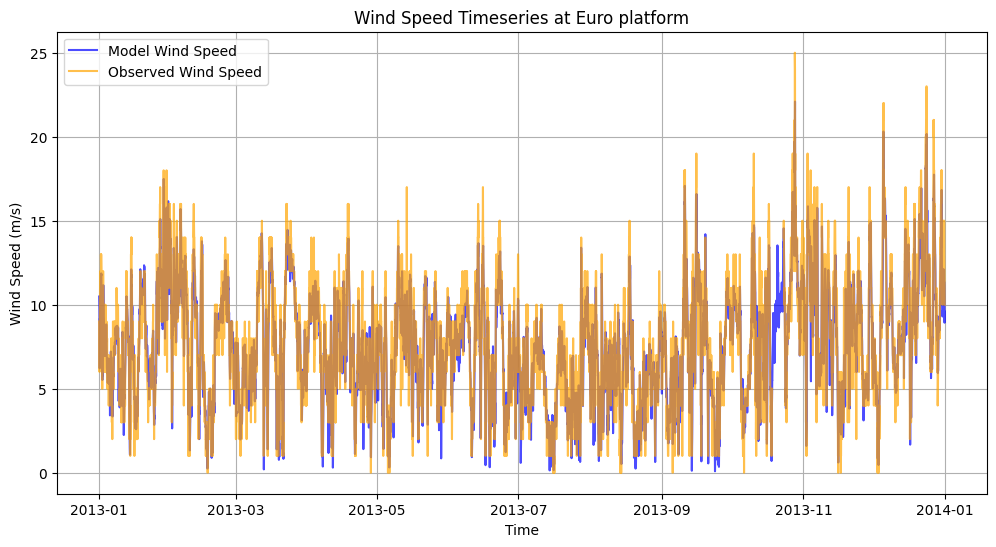

In [15]:
import matplotlib.pyplot as plt

# Select a station to plot (e.g., 'Euro platform')
station = 'Euro platform'

# Extract model wind speed and time
model_time = data_per_station[station]['time']
model_wind_speed = data_per_station[station]['wind_speed']

# Extract observed wind speed and time
obs_wind_speed = df_wind[(station, 'u')]

# Plot the timeseries
plt.figure(figsize=(12, 6))
plt.plot(model_time, model_wind_speed, label='Model Wind Speed', color='blue', alpha=0.7)
plt.plot(obs_wind_speed.index, obs_wind_speed, label='Observed Wind Speed', color='orange', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Wind Speed (m/s)')
plt.title(f'Wind Speed Timeseries at {station}')
plt.legend()
plt.grid()
plt.show()

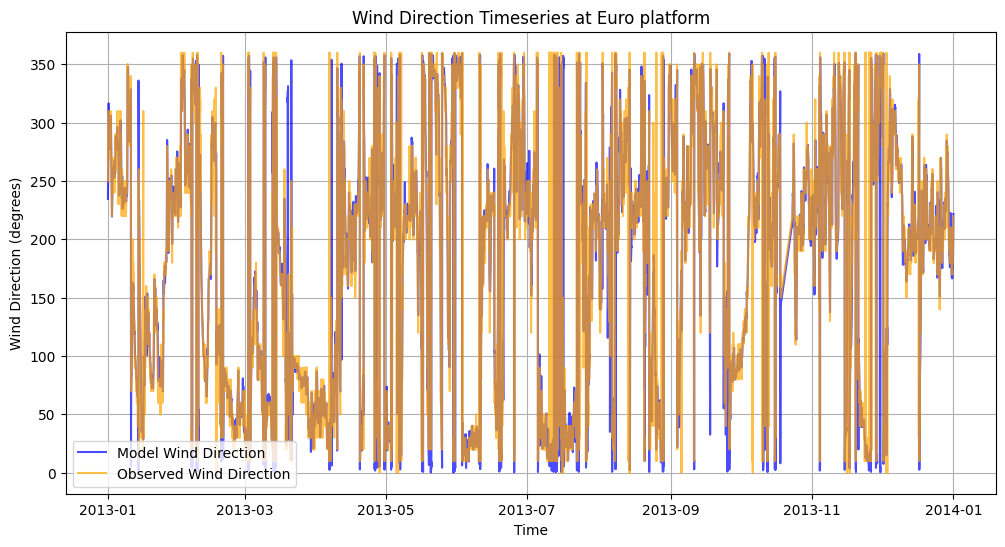

In [16]:
import matplotlib.pyplot as plt

# Select a station to plot (e.g., 'Euro platform')
station = 'Euro platform'

# Extract model wind speed and time
model_time = data_per_station[station]['time']
model_wind_direction = data_per_station[station]['wind_direction']

# Extract observed wind speed and time
obs_wind_direction = df_wind[(station, 'Direction')]

# Mask to remove NaN values from observed wind direction
mask = ~obs_wind_direction.isna()
obs_wind_direction = obs_wind_direction[mask]
model_wind_direction = model_wind_direction[mask]
model_time = model_time[mask]


# Plot the timeseries
plt.figure(figsize=(12, 6))
plt.plot(model_time, model_wind_direction, label='Model Wind Direction', color='blue', alpha=0.7)
plt.plot(obs_wind_direction.index, obs_wind_direction, label='Observed Wind Direction', color='orange', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Wind Direction (degrees)')
plt.title(f'Wind Direction Timeseries at {station}')
plt.legend()
plt.grid()
plt.show()

In [17]:
nan_count = obs_wind_direction.isna().sum()
print(f"Number of NaN values in obs_wind_direction: {nan_count}")

Number of NaN values in obs_wind_direction: 0


In [18]:
station = list(data_per_station.keys())[0]
print(type(data_per_station[station]))
print(data_per_station[station].keys())

station = list(df_wind.keys())[0]
print(type(df_wind[station]))
print(df_wind[station].keys())

<class 'dict'>
dict_keys(['point_hm0', 'point_tp', 'point_wavdir', 'point_dirspr', 'point_depth', 'wind_speed', 'wind_direction', 'time', 'station_x', 'station_y'])
<class 'pandas.core.series.Series'>
DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 01:00:00',
               '2013-01-01 02:00:00', '2013-01-01 03:00:00',
               '2013-01-01 04:00:00', '2013-01-01 05:00:00',
               '2013-01-01 06:00:00', '2013-01-01 07:00:00',
               '2013-01-01 08:00:00', '2013-01-01 09:00:00',
               ...
               '2013-12-31 14:00:00', '2013-12-31 15:00:00',
               '2013-12-31 16:00:00', '2013-12-31 17:00:00',
               '2013-12-31 18:00:00', '2013-12-31 19:00:00',
               '2013-12-31 20:00:00', '2013-12-31 21:00:00',
               '2013-12-31 22:00:00', '2013-12-31 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=8760, freq='h')


In [19]:
pinball_quantiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]

def _filter_valid_pairs(obs, pred):
    """Return obs and pred with NaNs removed (only keep entries where both are finite)."""
    obs = pd.to_numeric(np.asarray(obs), errors='coerce')
    pred = pd.to_numeric(np.asarray(pred), errors='coerce')
    mask = np.isfinite(obs) & np.isfinite(pred)
    if not np.any(mask):
        return np.array([]), np.array([])
    return obs[mask], pred[mask]

def rmse(obs, pred):
    obs, pred = _filter_valid_pairs(obs, pred)
    return np.sqrt(np.mean((pred - obs) ** 2)) if obs.size else np.nan

def bias(obs, pred):
    obs, pred = _filter_valid_pairs(obs, pred)
    return np.mean(pred - obs) if obs.size else np.nan

def scatter_index(obs, pred):
    obs, pred = _filter_valid_pairs(obs, pred)
    return rmse(obs, pred) / np.mean(obs) if obs.size else np.nan

def pinball_loss_from_list(obs, pred, quantiles):
    obs, pred = _filter_valid_pairs(obs, pred)
    if obs.size == 0:
        return [np.nan] * len(quantiles)
    delta = obs - pred
    return [np.mean(np.maximum(q * delta, (q - 1) * delta)) for q in quantiles]

def calculate_statistics(obs, pred, quantiles, verbose=False):
    rmse_val = rmse(obs, pred)
    bias_val = bias(obs, pred)
    si_val = scatter_index(obs, pred)
    pinball_vals = pinball_loss_from_list(obs, pred, quantiles)

    if verbose:
        print(f"RMSE: {rmse_val:.3f}, Bias: {bias_val:.3f}, SI: {si_val:.3f}")
        for q, val in zip(quantiles, pinball_vals):
            print(f"Pinball(q={q:.2f}): {val:.3f}")

    return rmse_val, bias_val, si_val, pinball_vals

def compare_wind_speed(df_wind, model_dict, quantiles):
    """
    Compare observed and modeled wind speed per station.

    df_wind: MultiIndex DataFrame with stations as level 0, 'u' as column
    model_dict: dict of {station: {'wind_speed': array, 'time': array}}
    """
    stats = {}

    for station, model_data in model_dict.items():
        if 'wind_speed' not in model_data or station not in df_wind.columns.get_level_values(0):
            continue

        # Observed
        obs_series = df_wind[station]['u']

        # Modeled
        model_speed = pd.Series(
            pd.to_numeric(model_data['wind_speed'], errors='coerce'),
            index=pd.to_datetime(model_data['time'])
        )

        # Align by timestamp
        combined = pd.concat([obs_series, model_speed], axis=1, keys=['obs', 'model']).dropna()
        if combined.empty:
            print(f"No overlapping data for {station}")
            continue

        # Calculate stats
        rmse_val, bias_val, si_val, pinball_vals = calculate_statistics(
            combined['obs'], combined['model'], quantiles
        )

        stats[station] = {
            'RMSE': rmse_val,
            'Bias': bias_val,
            'Scatter Index': si_val,
            'Pinball Loss': dict(zip(quantiles, pinball_vals)),
            'obs': combined['obs'].values,
            'model': combined['model'].values
        }

    return stats

df_stats_wind = compare_wind_speed(df_wind, data_per_station, pinball_quantiles)
print('wind_speed_stats')
pd.DataFrame(df_stats_wind).T

wind_speed_stats


,RMSE,Bias,Scatter Index,Pinball Loss,obs,model
Euro platform,1.412401,-0.254662,0.181956,"{0.05: 0.42009926130148106, 0.1: 0.43283235249...","[9.0, 9.0, 8.0, 8.0, 6.0, 7.0, 9.0, 9.0, 10.0,...","[10.487531, 10.038865, 9.692664, 8.488397, 6.9..."
Platform D15-A,1.613541,-0.192566,0.1964,"{0.05: 0.5461589215514975, 0.1: 0.555787245661...","[7.0, 6.0, 6.0, 8.0, 9.0, 10.0, 11.0, 10.0, 11...","[6.5824075, 7.310621, 8.324168, 7.7838297, 8.1..."
Platform Hoorn Q1-A,1.506293,-0.360625,0.185358,"{0.05: 0.4082717539256598, 0.1: 0.426303008300...","[9.0, 9.0, 6.0, 5.0, 7.0, 8.0, 9.0, 10.0, 10.0...","[9.527594, 9.021631, 8.369311, 7.412473, 6.531..."
K13 Alpha,1.413649,-0.25162,0.175335,"{0.05: 0.42655625608252135, 0.1: 0.43913727938...","[6.0, 5.0, 5.0, 7.0, 7.0, 9.0, 11.0, 10.0, 10....","[7.843112, 7.7590528, 7.4845862, 7.573868, 7.7..."
Platform F16-A,1.671548,0.07446,0.20923,"{0.05: 0.679039699983141, 0.1: 0.6753166799488...","[7.0, 6.0, 5.0, 5.0, 6.0, 8.0, 8.0, 7.0, 7.0, ...","[6.773236, 6.3446655, 6.7188387, 7.0325546, 6...."
A12 platform,1.395388,-0.153491,0.167966,"{0.05: 0.4626021767593303, 0.1: 0.470276717465...","[8.0, 7.0, 7.0, 8.0, 10.0, 10.0, 9.0, 9.0, 10....","[7.923767, 7.9415836, 8.691335, 8.7198925, 8.8..."


In [20]:
from sklearn.linear_model import LinearRegression
def plot_wind_speed_comparison(stats, output_dir="./wind_speed_comparison"):
    """
    Create scatter and QQ plots for each station, annotated with RMSE, Bias, SI, and Pinball Loss.
    """
    os.makedirs(output_dir, exist_ok=True)

    for station, s in stats.items():
        obs = np.asarray(s['obs'], dtype=float)
        model = np.asarray(s['model'], dtype=float)
        mask = np.isfinite(obs) & np.isfinite(model)
        if not np.any(mask):
            continue

        obs, model = obs[mask], model[mask]
        min_val, max_val = np.nanmin([obs, model]), np.nanmax([obs, model])

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        scatter_ax, qq_ax = axes

        # ----------------------------
        # Scatter Plot
        # ----------------------------
        scatter_ax.plot([min_val, max_val], [min_val, max_val], 'k--', label='1:1 line')
        scatter_ax.scatter(obs, model, color='blue', alpha=0.5, s=10)
        scatter_ax.set_xlabel("Observed Wind Speed (m/s)")
        scatter_ax.set_ylabel("Modeled Wind Speed (m/s)")
        scatter_ax.set_title(f"{station} - Scatter Plot")
        scatter_ax.grid(True)

        # Linear regression
        reg = LinearRegression().fit(obs.reshape(-1, 1), model)
        scatter_ax.plot(
            [min_val, max_val],
            reg.predict([[min_val], [max_val]]),
            color='red',
            lw=2,
            label=f"Fit: y={reg.coef_[0]:.2f}x+{reg.intercept_:.2f}"
        )
        scatter_ax.legend()

        # ----------------------------
        # QQ Plot
        # ----------------------------
        obs_sorted, model_sorted = np.sort(obs), np.sort(model)
        qq_ax.plot(obs_sorted, model_sorted, 'bo', markersize=3, alpha=0.5)
        qq_ax.plot([min_val, max_val], [min_val, max_val], 'k--')
        qq_ax.set_xlabel("Observed Quantiles (m/s)")
        qq_ax.set_ylabel("Modeled Quantiles (m/s)")
        qq_ax.set_title(f"{station} - QQ Plot")
        qq_ax.grid(True)

        # Annotate stats
        text = (
            f"RMSE: {s['RMSE']:.2f}\n"
            f"Bias: {s['Bias']:.2f}\n"
            f"SI: {s['Scatter Index']:.2f}\n"
        )
        for q, pl in s['Pinball Loss'].items():
            text += f"PL(q={q:.2f}): {pl:.3f}\n"

        qq_ax.text(
            0.98, 0.02, text,
            transform=qq_ax.transAxes,
            fontsize=8, va='bottom', ha='right',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
        )

        plt.suptitle(f"Wind Speed Comparison - {station}", fontsize=14)
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"{station}_wind_speed_comparison.png"), dpi=300)
        plt.close(fig)


# ===============================================================
# --- 4. Run the full workflow ---
# ===============================================================
pinball_quantiles = [0.05,0.1,0.25,0.5,0.75,0.9,0.95]
plot_wind_speed_comparison(df_stats_wind, output_dir)

In [21]:
def _filter_valid_angle_pairs(obs, pred, time):
    """Return obs, pred, and time with NaNs removed (only keep entries where both are finite)."""
    obs = pd.to_numeric(np.asarray(obs), errors='coerce')
    pred = pd.to_numeric(np.asarray(pred), errors='coerce')
    mask = np.isfinite(obs) & np.isfinite(pred)
    if not np.any(mask):  # No valid data
        return np.array([]), np.array([]), np.array([])
    return obs[mask], pred[mask], time[mask]

def angular_diffs(obs_angles, pred_angles):
    """Compute angular differences between observed and predicted angles."""
    obs_angles_rad = np.deg2rad(obs_angles)
    pred_angles_rad = np.deg2rad(pred_angles)
    angular_diffs_rad = np.arctan2(np.sin(pred_angles_rad - obs_angles_rad),
                                   np.cos(pred_angles_rad - obs_angles_rad))
    return np.rad2deg(angular_diffs_rad)

def angular_RMSE(obs_angles, pred_angles):
    """Compute angular RMSE between observed and predicted angles."""
    diffs = angular_diffs(obs_angles, pred_angles)
    return np.sqrt(np.mean(diffs ** 2)) if diffs.size > 0 else np.nan

# ---------- Create comparison DataFrame ----------

def create_df_wind_directions(df_obs, df_model):
    """
    Compare observed (df_obs) and modeled (df_model) wind direction per station.
    df_obs: MultiIndex DataFrame or dict-like with ['Direction'] per station.
    df_model: dict of dicts with keys ['wind_direction', 'time'] etc.
    """
    df_directions = {}

    for station in df_model.keys():
        # Skip non-station keys
        if not isinstance(df_model[station], dict):
            continue

        if 'wind_direction' not in df_model[station]:
            print(f"Skipping {station} (no wind_direction key)")
            continue

        if station not in df_obs.columns.get_level_values(0):
            print(f"Skipping {station} (no observations found)")
            continue

        # Observed wind direction
        obs_series = df_obs[station]['Direction']

        # Modeled wind direction: convert to Series
        model_dir = df_model[station]['wind_direction']
        model_time = pd.to_datetime(df_model[station]['time'])
        model_series = pd.Series(model_dir, index=model_time, name='Direction')

        # Align by time (inner join)
        df_combined = pd.concat([obs_series, model_series], axis=1, keys=['obs', 'model']).dropna()
        if df_combined.empty:
            print(f"No overlapping data for station: {station}")
            continue

        # Compute differences
        obs_angles, pred_angles, time_angles = _filter_valid_angle_pairs(
            df_combined['obs'], df_combined['model'], df_combined.index.to_numpy()
        )

        diffs = angular_diffs(obs_angles, pred_angles)
        mean_err = np.mean(diffs)
        std_err = np.std(diffs)
        rmse = angular_RMSE(obs_angles, pred_angles)
        norm_err = np.deg2rad(diffs) / (2 * np.pi)

        df_directions[station] = {
            'time': time_angles,
            'direction_obs': obs_angles,
            'direction_model': pred_angles,
            'direction_error': diffs,
            'direction_error_normalised': norm_err,
            'direction_error_mean': mean_err,
            'direction_error_std': std_err,
            'direction_error_rmse': rmse,
            'direction_error_norm_mean': np.mean(norm_err),
            'direction_error_norm_std': np.std(norm_err),
            'direction_error_norm_rmse': np.deg2rad(rmse) / (2 * np.pi)
        }

    return df_directions

# ---------- Plot functions ----------

def plot_direction(df_directions, save_path):
    outpath = os.path.join(save_path, "direction")
    os.makedirs(outpath, exist_ok=True)

    for station, stats in df_directions.items():
        times = stats['time']
        obs = stats['direction_obs']
        model = stats['direction_model']

        plt.figure(figsize=(12, 6))
        plt.plot(times, obs, label='Observed Wind Direction', color='tab:blue')
        plt.plot(times, model, label='Modeled Wind Direction', color='tab:orange')
        plt.ylim(-10, 370)
        plt.ylabel('Wind Direction (deg)')
        plt.xlabel('Time')
        plt.title(f"Mean Wind Direction: {station}")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(outpath, f"Wind_direction_timeseries_{station.replace(' ', '_')}.png"))
        plt.close()

def plot_direction_error(df_directions, save_path, title):
    outpath = os.path.join(save_path, "direction")
    os.makedirs(outpath, exist_ok=True)

    for station, stats in df_directions.items():
        plt.figure(figsize=(10, 6))
        plt.scatter(stats['time'], stats['direction_error'], label='Wind Direction Error', s=10)
        plt.axhline(stats['direction_error_mean'], color='red', linestyle='--', label='Mean Error')
        plt.axhline(stats['direction_error_mean'] + stats['direction_error_std'], color='orange', linestyle='--', label='±1 Std Dev')
        plt.axhline(stats['direction_error_mean'] - stats['direction_error_std'], color='orange', linestyle='--')
        plt.axhline(-180, color='gray', linestyle=':', linewidth=1)
        plt.axhline(0, color='black', linestyle='-', linewidth=1)
        plt.axhline(180, color='gray', linestyle=':', linewidth=1)
        plt.ylim(-180, 180)
        plt.title(f"{title} – {station}")
        plt.xlabel("Time")
        plt.ylabel("Error (degrees)")
        plt.legend(loc='upper right')

        textstr = (
            f"Mean error: {stats['direction_error_mean']:.2f}°\n"
            f"Std dev: {stats['direction_error_std']:.2f}°\n"
            f"RMSE: {stats['direction_error_rmse']:.2f}°"
        )
        plt.gca().text(
            0.98, 0.02, textstr,
            transform=plt.gca().transAxes,
            fontsize=10,
            verticalalignment='bottom',
            horizontalalignment='right',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8)
        )

        plt.tight_layout()
        plt.savefig(os.path.join(outpath, f"Wind_direction_error_{station.replace(' ', '_')}.png"))
        plt.close()

def plot_direction_error_histogram(df_directions, save_path, title):
    outpath = os.path.join(save_path, "direction")
    os.makedirs(outpath, exist_ok=True)

    for station, stats in df_directions.items():
        errors = np.array(stats['direction_error'])
        errors = errors[~np.isnan(errors)]

        plt.figure(figsize=(10, 6))
        plt.hist(errors, bins=72, color='steelblue', edgecolor='black', alpha=0.7)

        mean_err = stats['direction_error_mean']
        std_err = stats['direction_error_std']
        rmse = stats['direction_error_rmse']

        plt.axvline(mean_err, color='red', linestyle='--', label=f"Mean: {mean_err:.2f}°")
        plt.axvline(mean_err + std_err, color='orange', linestyle='--', label=f"Mean ± Std")
        plt.axvline(mean_err - std_err, color='orange', linestyle='--')
        plt.legend()

        plt.title(f"{title} – {station}")
        plt.xlabel("Wind Direction Error (°)")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(outpath, f"Wind_direction_error_hist_{station.replace(' ', '_')}.png"))
        plt.close()

# ---------- Run example ----------

# df_wind = your observed wind dataset (multi-station, includes 'Direction')
# data_per_station = your modeled data (same structure, includes 'Direction')

df_directions = create_df_wind_directions(df_wind, data_per_station)

plot_direction(df_directions, output_dir)
plot_direction_error(df_directions, output_dir, "Model vs Observed Wind Direction Error")
plot_direction_error_histogram(df_directions, output_dir, "Model vs Observed Wind Direction Error Histogram")

Skipping North Cormorant (no observations found)
Skipping IJmuiden munitiestortplaats (no observations found)


In [ ]:
# Filter df_wind for the storm period
# Define the storm period
storm_start = np.datetime64('2013-12-01')
storm_end = np.datetime64('2013-12-08')

df_wind_storm = df_wind.loc[storm_start:storm_end]

# Filter data_per_station for the storm period
data_per_station_storm = {}
for station, data in data_per_station.items():
    mask = (data['time'] >= storm_start) & (data['time'] <= storm_end)
    data_per_station_storm[station] = {
        var: values[mask] if isinstance(values, np.ndarray) and len(values) == len(mask) else values
        for var, values in data.items()
    }

# Filter obs_data_per_station for the storm period
obs_data_per_station_storm = {}
for station, data in obs_data_per_station.items():
    if 'time' in data:
        mask = (data['time'] >= storm_start) & (data['time'] <= storm_end)
        obs_data_per_station_storm[station] = {
            var: values[mask] if isinstance(values, (np.ndarray, pd.Series)) and len(values) == len(mask) else values
            for var, values in data.items()
        }

# Also filter df_directions (dict created by create_df_wind_directions) for the storm period
# Result: df_directions_storm with same structure but arrays restricted to the storm interval
df_directions_storm = {}
for station, stats in df_directions.items():
    times = np.asarray(stats.get('time', []))
    if times.size == 0:
        # nothing to filter, keep as-is
        df_directions_storm[station] = stats.copy()
        continue
    mask = (times >= storm_start) & (times <= storm_end)
    df_directions_storm[station] = {
        k: (v[mask] if hasattr(v, "__len__") and len(v) == len(times) else v)
        for k, v in stats.items()
    }

In [26]:
plot_direction(df_directions, os.path.join(output_dir))
plot_direction_error(df_directions, os.path.join(output_dir), "Model vs Observed Wind Direction Error for 2023")
plot_direction_error_histogram(df_directions, os.path.join(output_dir), "Model vs Observed Wind Direction Error Histogram for 2023")

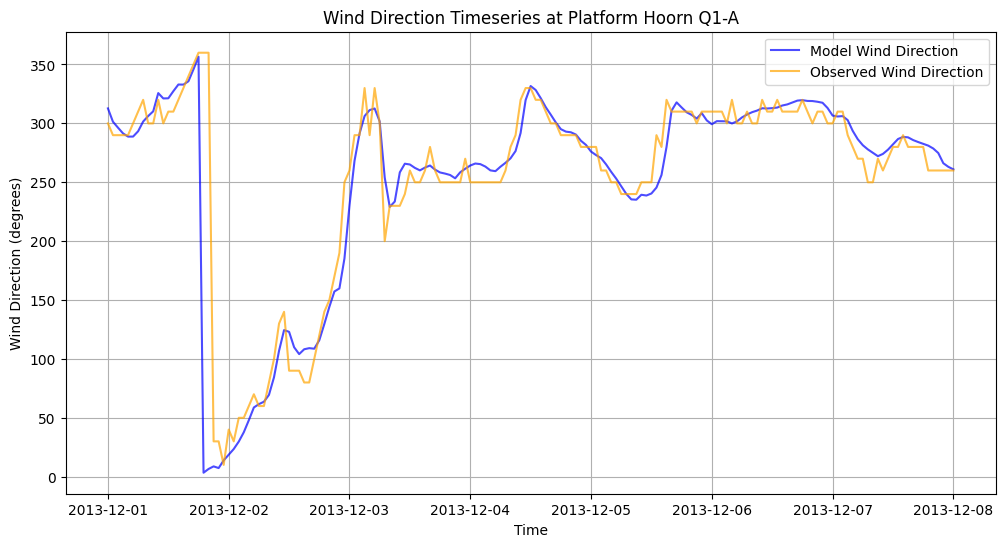

In [53]:
# Select a station to plot (e.g., 'Euro platform')
station = 'Platform Hoorn Q1-A'

# Extract model wind speed and time
model_time = data_per_station_storm[station]['time']
model_wind_direction = data_per_station_storm[station]['wind_direction']

# Extract observed wind speed and time
obs_wind_direction = df_wind_storm[(station, 'Direction')]

# Mask to remove NaN values from observed wind direction
mask = ~obs_wind_direction.isna()
obs_wind_direction = obs_wind_direction[mask]
model_wind_direction = model_wind_direction[mask]
model_time = model_time[mask]


# Plot the timeseries
plt.figure(figsize=(12, 6))
plt.plot(model_time, model_wind_direction, label='Model Wind Direction', color='blue', alpha=0.7)
plt.plot(obs_wind_direction.index, obs_wind_direction, label='Observed Wind Direction', color='orange', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Wind Direction (degrees)')
plt.title(f'Wind Direction Timeseries at {station}')
plt.legend()
plt.grid()
plt.show()

In [57]:
import os

import matplotlib.pyplot as plt

def plot_wave_height_and_wind_speed(data_per_station, obs_data_per_station, df_wind, output_dir):
    """
    Plot significant wave height and wind speed for each station.

    Args:
        data_per_station (dict): Modeled data per station.
        obs_data_per_station (dict): Observed data per station.
        df_wind (pd.DataFrame): Wind data.
        output_dir (str): Directory to save the plots.
    """
    os.makedirs(output_dir, exist_ok=True)

    for station in data_per_station.keys():

        if station not in obs_data_per_station or not obs_data_per_station[station]:
            print(f"Skipping {station} due to missing or empty observed data.")
            continue

        if (station, 'u') not in df_wind.columns:
            print(f"Skipping {station} due to missing wind data.")
            continue

        # Extract modeled significant wave height and wind speed
        model_time = data_per_station[station]['time']
        model_hm0 = data_per_station[station]['point_hm0']
        model_wind_speed = data_per_station[station]['wind_speed']

        # Extract observed significant wave height
        obs_time = obs_data_per_station[station]['time']
        obs_hm0 = obs_data_per_station[station]['hm0']

        # Extract observed wind speed
        obs_wind_speed = df_wind[(station, 'u')]

        # Plot the data
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plot significant wave height on the left y-axis
        ax1.plot(model_time, model_hm0, label='Modeled Hm0', color='blue', alpha=0.7)
        ax1.scatter(obs_time, obs_hm0, label='Observed Hm0', color='lightblue', marker='x', alpha=0.7)
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Significant Wave Height [m]', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.legend(loc='upper left')
        ax1.grid()

        # Plot wind speed on the right y-axis
        ax2 = ax1.twinx()
        ax2.plot(model_time, model_wind_speed, label='Modeled Wind Speed', color='green', alpha=0.7)
        ax2.scatter(obs_wind_speed.index, obs_wind_speed, label='Observed Wind Speed', color='lightgreen', marker='x', alpha=0.7)
        ax2.set_ylabel('Wind Speed [m/s]', color='green')
        ax2.tick_params(axis='y', labelcolor='green')
        ax2.legend(loc='upper right')

        # Title and save the plot
        plt.title(f'Significant Wave Height and Wind Speed at {station}')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'{station.replace(" ", "_")}_wave_height_wind_speed.png'), dpi=300)
        plt.close(fig)

# Call the function
plot_wave_height_and_wind_speed(data_per_station_storm, obs_data_per_station_storm, df_wind_storm, output_dir)

Skipping North Cormorant due to missing wind data.
Skipping IJmuiden munitiestortplaats due to missing wind data.


In [67]:
import os

import matplotlib.pyplot as plt

def plot_wave_height_and_wind_speed_differences(data_per_station, obs_data_per_station, df_wind, output_dir):
    """
    Plot differences between modeled and observed significant wave height and wind speed for each station.

    Args:
        data_per_station (dict): Modeled data per station.
        obs_data_per_station (dict): Observed data per station.
        df_wind (pd.DataFrame): Wind data.
        output_dir (str): Directory to save the plots.
    """
    os.makedirs(output_dir, exist_ok=True)

    for station in data_per_station.keys():
        if station not in obs_data_per_station or not obs_data_per_station[station]:
            print(f"Skipping {station} due to missing or empty observed data.")
            continue

        if (station, 'u') not in df_wind.columns:
            print(f"Skipping {station} due to missing wind data.")
            continue

        # Extract modeled data
        model_time = data_per_station[station]['time']
        model_hm0 = data_per_station[station]['point_hm0']
        model_wind_speed = data_per_station[station]['wind_speed']

        # Extract observed data
        obs_time = obs_data_per_station[station]['time']
        obs_hm0 = obs_data_per_station[station]['hm0']
        obs_wind_speed = df_wind[(station, 'u')]

        # Align modeled and observed data by time
        wave_diff = []
        wind_diff = []
        common_times = []

        for t in model_time:
            if t in obs_time.values and t in obs_wind_speed.index:
                wave_diff.append(model_hm0[model_time == t][0] - obs_hm0[obs_time == t].values[0])
                wind_diff.append(model_wind_speed[model_time == t][0] - obs_wind_speed[t])
                common_times.append(t)

        if not common_times:
            print(f"No overlapping data for station {station}.")
            continue

        # Convert to arrays
        wave_diff = np.array(wave_diff)
        wind_diff = np.array(wind_diff)

        # Compute symmetric limits so 0 is in the middle, and all values are included
        wave_max_abs = np.nanmax(np.abs(wave_diff))
        wind_max_abs = np.nanmax(np.abs(wind_diff))

        # Add a 10% margin for visual clarity
        wave_lim = wave_max_abs * 1.1
        wind_lim = wind_max_abs * 1.1

        # Plot
        fig, ax1 = plt.subplots(figsize=(12, 6))

        ax1.plot(common_times, wave_diff, label='Wave Height Δ (Model - Obs)', color='blue', alpha=0.7)
        ax1.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.7)
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Wave Height Difference [m]', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.set_ylim(-wave_lim, wave_lim)
        ax1.grid(True, alpha=0.3)

        ax2 = ax1.twinx()
        ax2.plot(common_times, wind_diff, label='Wind Speed Δ (Model - Obs)', color='green', alpha=0.7)
        ax2.set_ylabel('Wind Speed Difference [m/s]', color='green')
        ax2.tick_params(axis='y', labelcolor='green')
        ax2.set_ylim(-wind_lim, wind_lim)

        # Add title and legend
        plt.title(f'Differences in Wave Height and Wind Speed at {station}')
        fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

        # Save and close
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'{station.replace(" ", "_")}_wave_wind_differences.png'), dpi=300)
        plt.close()

plot_wave_height_and_wind_speed_differences(data_per_station_storm, obs_data_per_station_storm, df_wind_storm, output_dir)

Skipping North Cormorant due to missing wind data.
Skipping IJmuiden munitiestortplaats due to missing wind data.
No overlapping data for station A12 platform.


In [71]:
print(obs_data_per_station_storm['Euro platform'].keys())

dict_keys(['hm0', 't13', 'tmax', 'th0', 'year', 'time'])


In [73]:
def plot_wave_direction_and_wind_direction(data_per_station, obs_data_per_station, df_wind, output_dir):
    """
    Plot significant wave height and wind speed for each station.

    Args:
        data_per_station (dict): Modeled data per station.
        obs_data_per_station (dict): Observed data per station.
        df_wind (pd.DataFrame): Wind data.
        output_dir (str): Directory to save the plots.
    """
    os.makedirs(output_dir, exist_ok=True)

    for station in data_per_station.keys():

        if station not in obs_data_per_station or not obs_data_per_station[station]:
            print(f"Skipping {station} due to missing or empty observed data.")
            continue

        if (station, 'u') not in df_wind.columns:
            print(f"Skipping {station} due to missing wind data.")
            continue

        # Extract modeled significant wave height and wind speed
        model_time = data_per_station[station]['time']
        model_wave_direction = data_per_station[station]['point_wavdir']
        model_wind_direction = data_per_station[station]['wind_direction']

        # Extract observed significant wave height
        obs_time = obs_data_per_station[station]['time']
        obs_wave_direction = obs_data_per_station[station]['th0']

        # Extract observed wind direction
        obs_wind_direction = df_wind[(station, 'Direction')]

        # Filter out invalid values in observed wind direction
        obs_wind_direction = obs_wind_direction.dropna()

        # Plot the data
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plot significant wave height on the left y-axis
        ax1.plot(model_time, model_wave_direction, label='Modeled Wave Direction', color='blue', alpha=0.7)
        ax1.scatter(obs_time, obs_wave_direction, label='Observed Wave Direction', color='lightblue', marker='x', alpha=0.7)
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Significant Wave Direction [°]', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.legend(loc='upper left')
        ax1.grid()

        # Plot wind direction on the right y-axis
        ax2 = ax1.twinx()
        ax2.plot(model_time, model_wind_direction, label='Modeled Wind Direction', color='green', alpha=0.7)
        ax2.scatter(obs_wind_direction.index, obs_wind_direction, label='Observed Wind Direction', color='lightgreen', marker='x', alpha=0.7)
        ax2.set_ylabel('Wind Direction [°]', color='green')
        ax2.tick_params(axis='y', labelcolor='green')
        ax2.legend(loc='upper right')

        # Title and save the plot
        plt.title(f'Significant Wave Direction and Wind Direction at {station}')
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'{station.replace(" ", "_")}_wave_direction_wind_direction.png'), dpi=300)
        plt.close(fig)

# Call the function
plot_wave_direction_and_wind_direction(data_per_station_storm, obs_data_per_station_storm, df_wind_storm, output_dir)

Skipping North Cormorant due to missing wind data.
Skipping IJmuiden munitiestortplaats due to missing wind data.


In [78]:
def plot_directional_differences(data_per_station, obs_data_per_station, df_wind, output_dir):
    """
    Plot differences between modeled and observed wave and wind directions for each station.

    Args:
        data_per_station (dict): Modeled data per station.
        obs_data_per_station (dict): Observed data per station.
        df_wind (pd.DataFrame): Wind data.
        output_dir (str): Directory to save the plots.
    """
    os.makedirs(output_dir, exist_ok=True)

    for station in data_per_station.keys():
        if station not in obs_data_per_station or not obs_data_per_station[station]:
            print(f"Skipping {station} due to missing or empty observed data.")
            continue

        if (station, 'Direction') not in df_wind.columns:
            print(f"Skipping {station} due to missing wind direction data.")
            continue

        # Extract modeled data
        model_time = data_per_station[station]['time']
        model_wave_direction = data_per_station[station]['point_wavdir']
        model_wind_direction = data_per_station[station]['wind_direction']

        # Extract observed data
        obs_time = obs_data_per_station[station]['time']
        obs_wave_direction = obs_data_per_station[station]['th0']
        obs_wind_direction = df_wind[(station, 'Direction')].dropna()

        # Align observed and modeled wave direction data by time
        obs_wave_direction = obs_wave_direction[obs_time.isin(model_time)]
        model_wave_direction = model_wave_direction[np.isin(model_time, obs_time)]
        model_time_wave = model_time[np.isin(model_time, obs_time)]

        # Align observed and modeled wind direction data by time
        obs_wind_direction = obs_wind_direction[obs_wind_direction.index.isin(model_time)]
        model_wind_direction = model_wind_direction[np.isin(model_time, obs_wind_direction.index)]
        model_time_wind = model_time[np.isin(model_time, obs_wind_direction.index)]

        # Filter valid pairs (custom function)
        wave_obs, wave_pred, wave_time = _filter_valid_angle_pairs(
            obs_wave_direction, model_wave_direction, model_time_wave
        )
        wind_obs, wind_pred, wind_time = _filter_valid_angle_pairs(
            obs_wind_direction, model_wind_direction, model_time_wind
        )

        if len(wave_time) == 0 and len(wind_time) == 0:
            print(f"No valid data for station {station}.")
            continue

        # Compute angular differences
        wave_diff = angular_diffs(wave_obs, wave_pred) if len(wave_time) > 0 else np.array([])
        wind_diff = angular_diffs(wind_obs, wind_pred) if len(wind_time) > 0 else np.array([])

        # Compute shared symmetric limits so that both datasets use the same y-scale
        max_abs_diff = 0
        if len(wave_diff) > 0:
            max_abs_diff = max(max_abs_diff, np.nanmax(np.abs(wave_diff)))
        if len(wind_diff) > 0:
            max_abs_diff = max(max_abs_diff, np.nanmax(np.abs(wind_diff)))

        # Add a small margin and make the limits symmetric around zero
        ylim = max_abs_diff * 1.1 if max_abs_diff > 0 else 10  # fallback ±10°
        ylim = max(ylim, 5)  # ensure nonzero range
        ymin, ymax = -ylim, ylim

        # Plot
        fig, ax1 = plt.subplots(figsize=(12, 6))

        ax1.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.7)
        ax1.grid(True, alpha=0.3)
        ax1.set_xlabel('Time')
        ax1.set_ylim(ymin, ymax)
        ax1.set_ylabel('Direction Difference [°]', color='black')
        ax1.tick_params(axis='y', labelcolor='black')

        # Plot wave direction differences
        if len(wave_time) > 0:
            ax1.plot(wave_time, wave_diff, label='Wave Direction Δ (Model - Obs)', color='blue', alpha=0.7)

        # Plot wind direction differences (same axis, since same unit and scale)
        if len(wind_time) > 0:
            ax1.plot(wind_time, wind_diff, label='Wind Direction Δ (Model - Obs)', color='green', alpha=0.7)

        # Title and legend
        plt.title(f'Directional Differences in Wave and Wind Directions at {station}')
        fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

        # Save and close
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f'{station.replace(" ", "_")}_directional_differences.png'), dpi=300)
        plt.close()

# Call the function
plot_directional_differences(data_per_station_storm, obs_data_per_station_storm, df_wind_storm, output_dir)


Skipping North Cormorant due to missing wind direction data.
Skipping IJmuiden munitiestortplaats due to missing wind direction data.
